<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/gan_mixture_of_gaussians.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook implements a Generative Adversarial Network to fit a synthetic dataset generated from a mixture of Gaussians in 2D.

The code was adapted from the ODEGAN code here: https://github.com/deepmind/deepmind-research/blob/master/ode_gan/odegan_mog16.ipynb. The original notebook was created by **Chongli Qin‎**.

Some modifications made by **Mihaela Rosca** [here](https://github.com/probml/probml-notebooks/blob/main/notebooks/gan_mog_mode_hopping.ipynb) were also incorporated.

# Imports

In [1]:
from typing import Sequence
import matplotlib.pyplot as plt

#%matplotlib inline

#%pip install -qq jax==0.3.14
import jax
import jax.numpy as jnp

try:
    import flax.linen as nn
    from flax.training import train_state
except ModuleNotFoundError:
    #%pip install -qq flax
    import flax.linen as nn
    from flax.training import train_state

try:
    import optax
except ModuleNotFoundError:
    #%pip install -qq optax
    import optax

import functools
import scipy as sp
import math

try:
    import seaborn as sns
except ModuleNotFoundError:
    #%pip install -qq seaborn
    import seaborn as sns

try:
    import probml_utils as pml
    from probml_utils import savefig, latexify
except ModuleNotFoundError:
    #%pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml
    from probml_utils import savefig, latexify

rng = jax.random.PRNGKey(0)

In [2]:
latexify(width_scale_factor=3, fig_height=1.5)

/home/mike_1102/miniconda3/envs/env02/lib/python3.11/site-packages/probml_utils/plotting.py:25: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


# Data Generation

Data is generated from a 2D mixture of Gaussians.

In [3]:
@functools.partial(jax.jit, static_argnums=(1,))
def real_data(rng, batch_size):
    mog_mean = jnp.array(
        [
            [1.50, 1.50],
            [1.50, 0.50],
            [1.50, -0.50],
            [1.50, -1.50],
            [0.50, 1.50],
            [0.50, 0.50],
            [0.50, -0.50],
            [0.50, -1.50],
            [-1.50, 1.50],
            [-1.50, 0.50],
            [-1.50, -0.50],
            [-1.50, -1.50],
            [-0.50, 1.50],
            [-0.50, 0.50],
            [-0.50, -0.50],
            [-0.50, -1.50],
        ]
    )
    temp = jnp.tile(mog_mean, (batch_size // 16 + 1, 1))
    mus = temp[0:batch_size, :]
    return mus + 0.02 * jax.random.normal(rng, shape=(batch_size, 2))

# Plotting

In [4]:
def plot_on_ax(ax, values, contours=None, bbox=None, xlabel="", ylabel="", title="", cmap="Blues"):
    kernel = sp.stats.gaussian_kde(values.T)

    ax.axis(bbox)
    ax.set_aspect(abs(bbox[1] - bbox[0]) / abs(bbox[3] - bbox[2]))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks([])
    ax.set_yticks([])

    xx, yy = jnp.mgrid[bbox[0] : bbox[1] : 300j, bbox[2] : bbox[3] : 300j]
    positions = jnp.vstack([xx.ravel(), yy.ravel()])

    f = jnp.reshape(kernel(positions).T, xx.shape)
    cfset = ax.contourf(xx, yy, f, cmap=cmap)
    if contours is not None:
        x = jnp.arange(-2.0, 2.0, 0.1)
        y = jnp.arange(-2.0, 2.0, 0.1)
        cx, cy = jnp.meshgrid(x, y)
        new_set = ax.contour(
            cx, cy, contours.squeeze().reshape(cx.shape), levels=20, colors="k", linewidths=0.8, alpha=0.5
        )
    ax.set_title(title)

# Models and Training

A multilayer perceptron with the ReLU activation function.

In [5]:
class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = jax.nn.relu(nn.Dense(features=feat)(x))
        x = nn.Dense(features=self.features[-1])(x)
        return x

The loss function for the discriminator is:

$$L_D(\phi, \theta) = \mathbb{E}_{p^*(x)} g(D_\phi(x)) + \mathbb{E}_{q(z)}h(D_\phi(G_\theta(z)))$$

where $g(t) = -\log t$, $h(t) = -\log(1 - t)$ as in the original GAN.

In [6]:
@jax.jit
def discriminator_step(disc_state, gen_state, latents, real_examples):
    def loss_fn(disc_params):
        fake_examples = gen_state.apply_fn(gen_state.params, latents)
        real_logits = disc_state.apply_fn(disc_params, real_examples)
        fake_logits = disc_state.apply_fn(disc_params, fake_examples)
        disc_real = -jax.nn.log_sigmoid(real_logits)	# D(x)=p(y=1|x)∈[0,1] gives the prob, so the logits from the MLP need to be converted to prob by sigmoid, then take -log();
        # log(1 - sigmoid(x)) = log_sigmoid(-x)
        disc_fake = -jax.nn.log_sigmoid(-fake_logits)
        return jnp.mean(disc_real + disc_fake)

    disc_loss, disc_grad = jax.value_and_grad(loss_fn)(disc_state.params)
    disc_state = disc_state.apply_gradients(grads=disc_grad)
    return disc_state, disc_loss

The loss function for the generator is:

$$L_G(\phi, \theta) = \mathbb{E}_{q(z)} l(D_\phi(G_\theta(z))$$

where $l(t) = -\log t$ for the non-saturating generator loss.

In [7]:
@jax.jit
def generator_step(disc_state, gen_state, latents):
    def loss_fn(gen_params):
        fake_examples = gen_state.apply_fn(gen_params, latents)
        fake_logits = disc_state.apply_fn(disc_state.params, fake_examples)
        disc_fake = -jax.nn.log_sigmoid(fake_logits)
        return jnp.mean(disc_fake)

    gen_loss, gen_grad = jax.value_and_grad(loss_fn)(gen_state.params)
    gen_state = gen_state.apply_gradients(grads=gen_grad)
    return gen_state, gen_loss

Perform a training step by first updating the discriminator parameters $\phi$ using the gradient $\nabla_\phi L_D (\phi, \theta)$ and then updating the generator parameters $\theta$ using the gradient $\nabla_\theta L_G (\phi, \theta)$.

In [8]:
@jax.jit
def train_step(disc_state, gen_state, latents, real_examples):
    disc_state, disc_loss = discriminator_step(disc_state, gen_state, latents, real_examples)
    gen_state, gen_loss = generator_step(disc_state, gen_state, latents)
    return disc_state, gen_state, disc_loss, gen_loss

In [9]:
batch_size = 512
latent_size = 32

discriminator = MLP(features=[25, 25, 1])	# D_φ(x) generates logit∈ℝ, then converted prob by sigmoid;
generator = MLP(features=[25, 25, 2])	# G_θ(z) generates fake sample (x,y)∈ℝ²;

In [10]:
# Initialize parameters for the discriminator and the generator
latents = jax.random.normal(rng, shape=(batch_size, latent_size))
real_examples = real_data(rng, batch_size)
disc_params = discriminator.init(rng, real_examples)
gen_params = generator.init(rng, latents)

/home/mike_1102/miniconda3/envs/env02/lib/python3.11/site-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


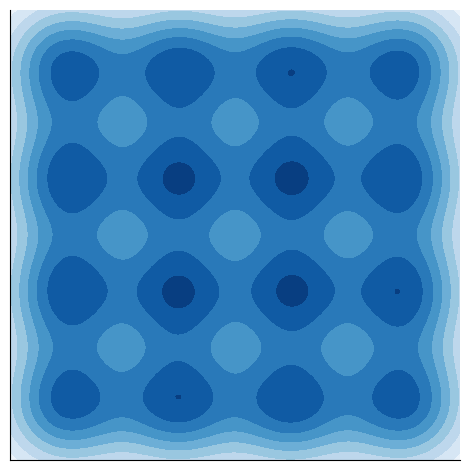

In [11]:
# Plot real examples
bbox = [-2, 2, -2, 2]
plot_on_ax(plt.gca(), real_examples, bbox=bbox)
plt.tight_layout()
sns.despine()
pml.savefig("gan_gmm_data.pdf")
plt.show()

In [12]:
# Create train states for the discriminator and the generator
lr = 0.05
disc_state = train_state.TrainState.create(
    apply_fn=discriminator.apply, params=disc_params, tx=optax.sgd(learning_rate=lr)
)
gen_state = train_state.TrainState.create(apply_fn=generator.apply, params=gen_params, tx=optax.sgd(learning_rate=lr))

In [13]:
# x and y grid for plotting discriminator contours
x = jnp.arange(-2.0, 2.0, 0.1)
y = jnp.arange(-2.0, 2.0, 0.1)
X, Y = jnp.meshgrid(x, y)
pairs = jnp.stack((X, Y), axis=-1)
pairs = jnp.reshape(pairs, (-1, 2))

# Latents for testing generator
test_latents = jax.random.normal(rng, shape=(batch_size * 10, latent_size))

In [14]:
num_iters = 20001
n_save = 2000
draw_contours = False
history = []

for i in range(num_iters):
    rng_iter = jax.random.fold_in(rng, i)
    data_rng, latent_rng = jax.random.split(rng_iter)
    # Sample minibatch of examples
    real_examples = real_data(data_rng, batch_size)
    # Sample minibatch of latents
    latents = jax.random.normal(latent_rng, shape=(batch_size, latent_size))
    # Update both the generator
    disc_state, gen_state, disc_loss, gen_loss = train_step(disc_state, gen_state, latents, real_examples)
    if i % n_save == 0:
        print(f"i = {i}, Discriminator Loss = {disc_loss}, " + f"Generator Loss = {gen_loss}")
        # Generate examples using the test latents
        fake_examples = gen_state.apply_fn(gen_state.params, test_latents)
        if draw_contours:
            real_logits = disc_state.apply_fn(disc_state.params, pairs)
            disc_contour = -real_logits + jax.nn.log_sigmoid(real_logits)
        else:
            disc_contour = None
        history.append((i, fake_examples, disc_contour, disc_loss, gen_loss))

i = 0, Discriminator Loss = 1.3994591236114502, Generator Loss = 0.7145957946777344
i = 2000, Discriminator Loss = 1.2395533323287964, Generator Loss = 0.8240096569061279
i = 4000, Discriminator Loss = 1.2077232599258423, Generator Loss = 0.6619774699211121
i = 6000, Discriminator Loss = 1.2940952777862549, Generator Loss = 1.4686102867126465
i = 8000, Discriminator Loss = 1.0743471384048462, Generator Loss = 0.7342479825019836
i = 10000, Discriminator Loss = 0.9305174946784973, Generator Loss = 0.9585802555084229
i = 12000, Discriminator Loss = 0.7325254678726196, Generator Loss = 3.498624324798584
i = 14000, Discriminator Loss = 0.549660325050354, Generator Loss = 2.7560861110687256
i = 16000, Discriminator Loss = 0.5863199234008789, Generator Loss = 3.5637757778167725
i = 18000, Discriminator Loss = 0.3601462244987488, Generator Loss = 5.934319972991943
i = 20000, Discriminator Loss = 0.17003032565116882, Generator Loss = 3.352945566177368


# Plot Results

Plot the data and the examples generated by the generator.

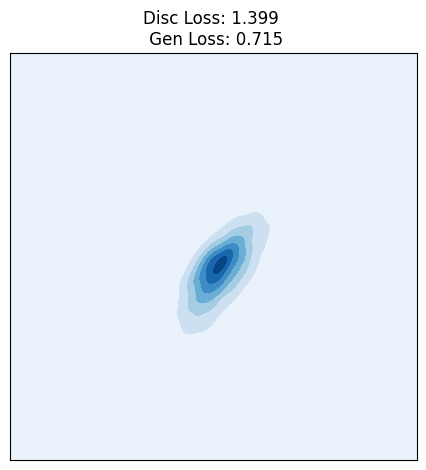

/home/mike_1102/miniconda3/envs/env02/lib/python3.11/site-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


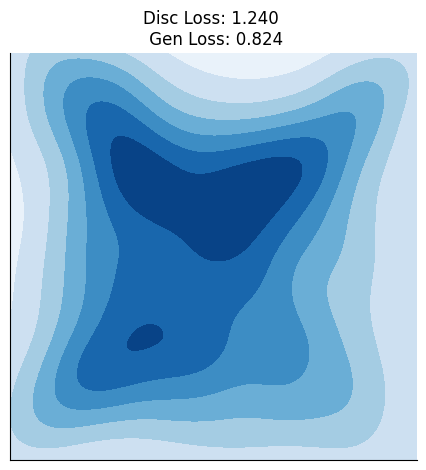

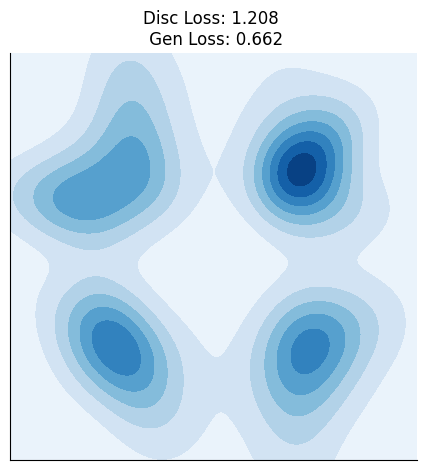

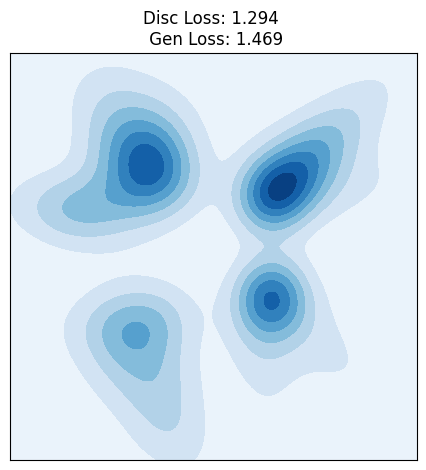

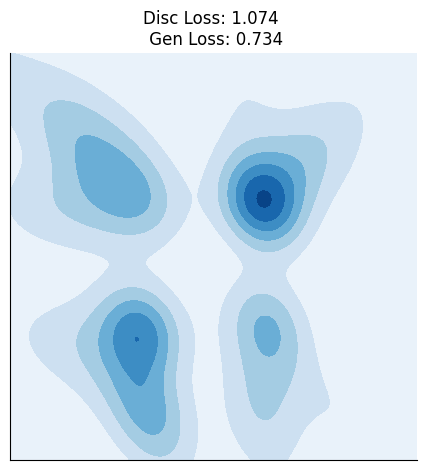

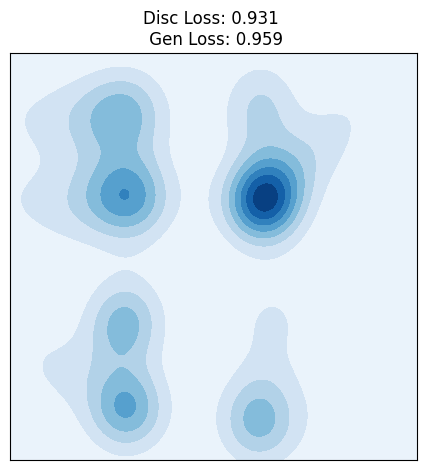

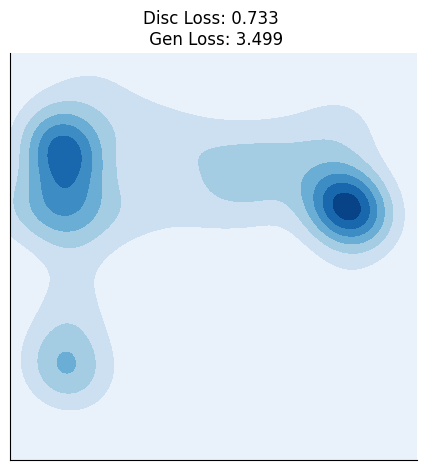

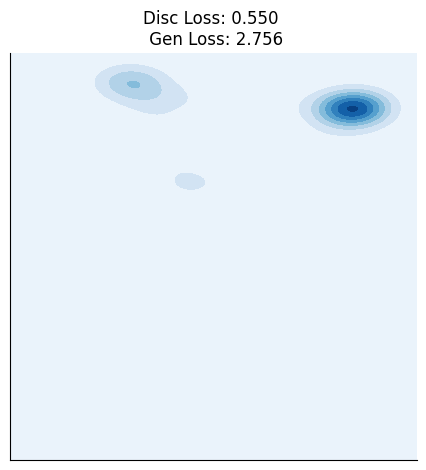

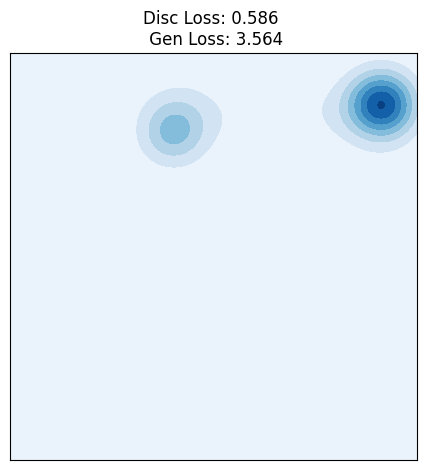

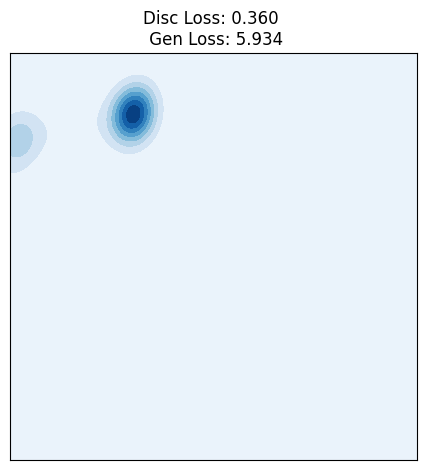

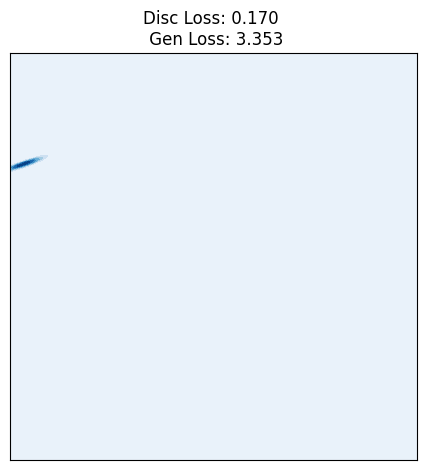

In [15]:
# Plot generated examples from history
for i, hist in enumerate(history):
    iter, fake_examples, contours, disc_loss, gen_loss = hist
    plot_on_ax(
        plt.gca(),
        fake_examples,
        contours=contours,
        bbox=bbox,
        title=f"Disc Loss: {disc_loss:.3f} \n Gen Loss: {gen_loss:.3f}",
    )

    if (iter == 2000) or (iter == 4000) or (iter == 8000) or (iter == 12000) or (iter == 14000):
        plt.tight_layout()
        sns.despine()
        pml.savefig(f"gan_gmm_iter_{iter}.pdf")
        plt.show()
    else:
        plt.tight_layout()
        # plt.savefig(f"gan_gmm_iter_{iter}.pdf")
        plt.show()

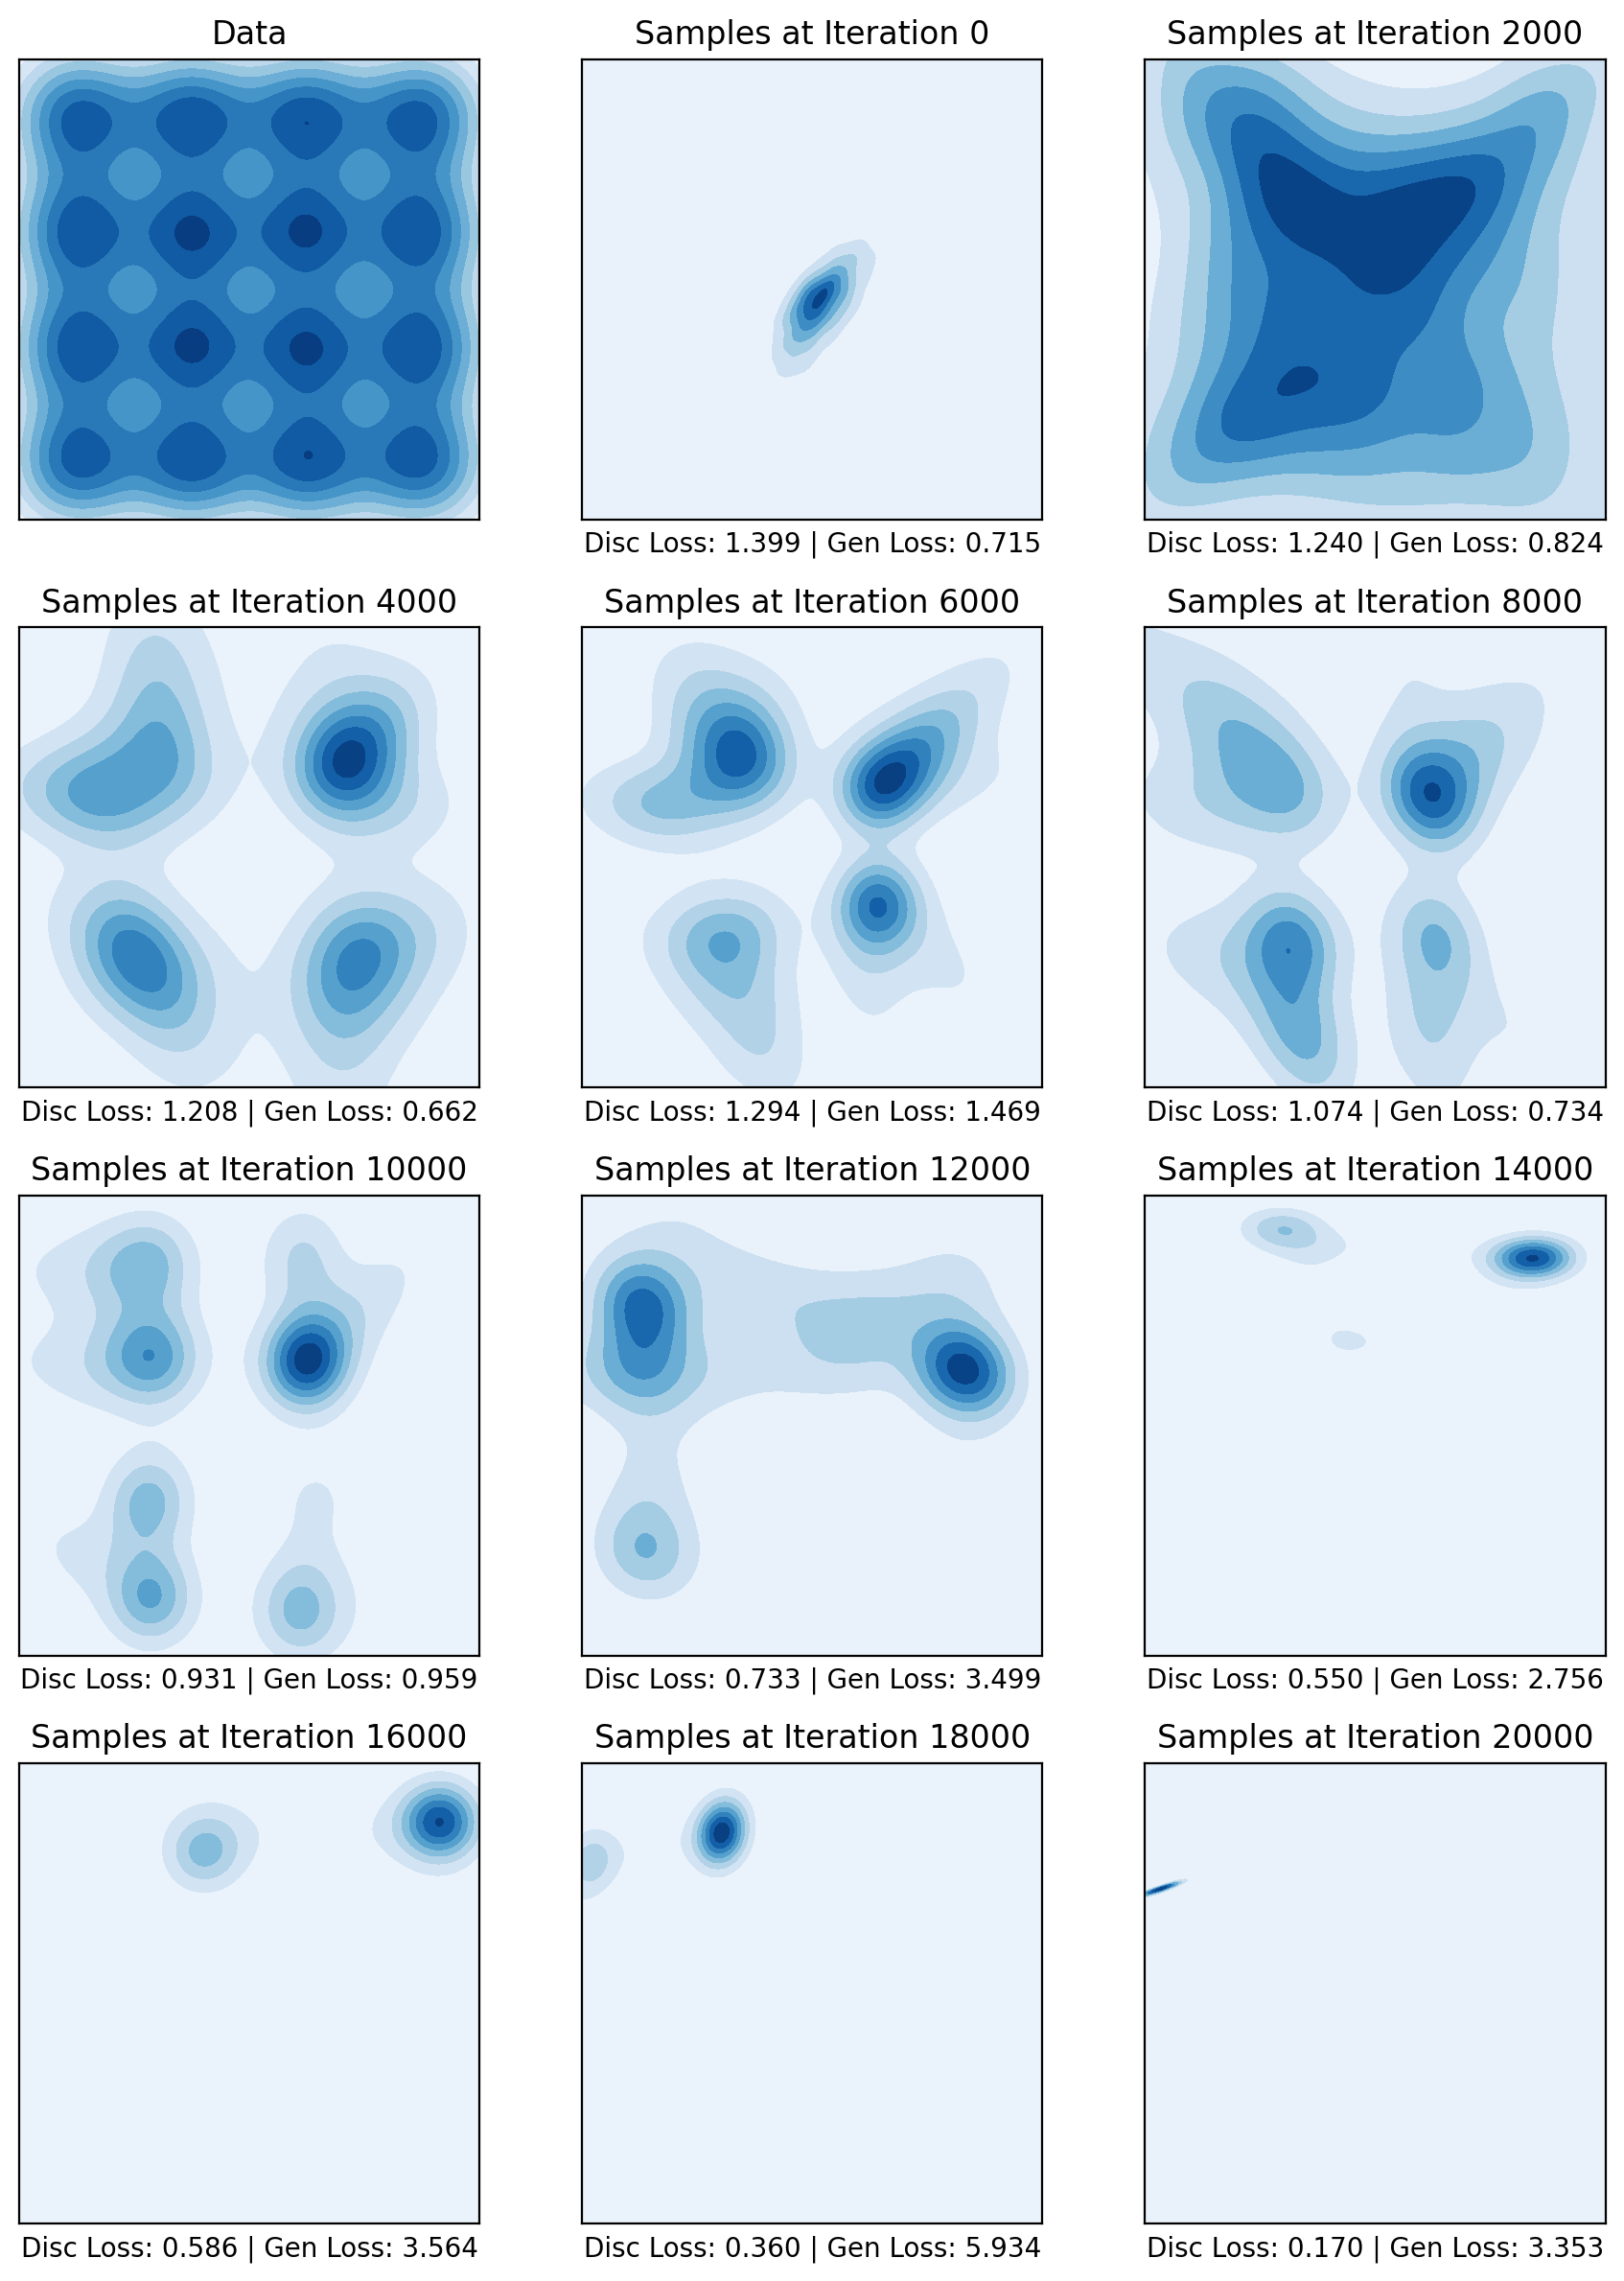

In [17]:
cols = 3
rows = math.ceil((len(history) + 1) / cols)
bbox = [-2, 2, -2, 2]

fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3), dpi=200)
axs = axs.flatten()

# Plot real examples
plot_on_ax(axs[0], real_examples, bbox=bbox, title="Data")

# Plot generated examples from history
for i, hist in enumerate(history):
    iter, fake_examples, contours, disc_loss, gen_loss = hist
    plot_on_ax(
        axs[i + 1],
        fake_examples,
        contours=contours,
        bbox=bbox,
        xlabel=f"Disc Loss: {disc_loss:.3f} | Gen Loss: {gen_loss:.3f}",
        title=f"Samples at Iteration {iter}",
    )

# Remove extra plots from the figure
for i in range(len(history) + 1, len(axs)):
    axs[i].remove()
plt.tight_layout()
plt.show()